In [61]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import log_loss, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import warnings
warnings.filterwarnings('ignore')

In [62]:
def choose_best_threshold(probas, target):
    ''' iterates over thresholds to choose the one with the highest f1 score '''
    results = dict()
    precision, recall, thresholds = precision_recall_curve(target, probas)
    f1_scores = 2 * recall * precision / (recall + precision)
    best_f1_ind = np.argmax(f1_scores)
    results['best_threshold'] = thresholds[best_f1_ind]
    results['validation_precision']      = precision[best_f1_ind]
    results['validation_recall']         = recall[best_f1_ind]
    results['validation_f1_score']  = np.max(f1_scores)
    return results 
    
def train_model_and_do_validation_predict(df_train, df_valid, target):
    ''' trains the model and predicts on validation set
        returns model and validation set predictions'''
    X, y = df_train.drop(columns=target), df_train[target]
    X_valid = df_valid.drop(columns=target)
    model = RandomForestClassifier(n_jobs=-1, n_estimators=256, min_samples_leaf=20, random_state=42).fit(X, y)
    return model, model.predict_proba(X_valid)[:, 1]

def score_production_predictions(df_prod, target, model, threshold):
    ''' computes the f1 score on the "production" dataset with the provided threshold '''
    X_prod = df_prod.drop(columns=target)
    P_prod = model.predict_proba(X_prod)[:, 1] > threshold
    return f1_score(df_prod[target], P_prod)


def train_optimize_and_predict_on_prod(train_val, df_prod, target):
    ''' the full test, validate, tune threhsold, and predict on "production data" sequence '''
    train, val = train_test_split(train_val, test_size=0.2, random_state=42)
    model, P_val = train_model_and_do_validation_predict(train, val, target)
    results = choose_best_threshold(P_val, val[target])
    prod_f1_score = score_production_predictions(df_prod, target, model, results['best_threshold'])
    results['prod_f1_score'] = prod_f1_score
    return results

def run_experiment(df, target):
    # set aside test set for final evaluation
    #     held out "test set" is called "df_prod" to denote that it's
    #     our best representation of what the model will be encountering "in prod"
    #     having the "untouched" class balance 
    train_val, df_prod = train_test_split(df, test_size=0.2, random_state=42) 

    # resampler - try different resamplers if you like
    resampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42) # 50/50 balanced undersampling
    train_val_resampled, _ = resampler.fit_resample(train_val, train_val[target])
        
    # experiment 1: 
    #  - train model on resampled data
    #  - pick optimal threshold based on validation set f1 score
    #  - predict on "production_data" and compare to our expectations
    #    as defined by validation set results
    resampled_results = train_optimize_and_predict_on_prod(train_val_resampled, df_prod, target)
    
    # experiment 2: 
    #   - same as experiment 1 but do not resample the data first
    raw_results = train_optimize_and_predict_on_prod(train_val, df_prod, target)
    
    results = pd.DataFrame([resampled_results, raw_results], index=['resampled', 'non-resampled']).T.round(2)
    return results

In [63]:
df = pd.read_csv('mapped-v2_imputed_mf5iter.csv')
target = 'DC201'

df_sample = df.sample(frac=0.1)
df_sample

,DC216,DC220,DC142a,DC024,DC025,DC205,DC206,DC207,DC208,DC209,...,DC237e,DC237f,DC241,DC242,DC244,DC246,DC252,DC270a,DC109,DC201
7851,3.0,55.0,119.0,8,0,2.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,3,0.0,1.0
13099,1.0,37.0,12.0,11,0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,4.0,1,0.0,1.0
3190,1.0,33.0,36.0,1,0,2.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,0.0,1.0
15279,3.0,36.0,70.0,12,0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,0.0,1.0
8082,3.0,52.0,63.0,8,0,2.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29476,2.0,61.0,42.0,26,1,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2,0.0,1.0
10929,1.0,35.0,24.0,11,0,13.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0,3.0,0.0
9915,1.0,62.0,90.0,10,0,2.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2,0.0,1.0
20198,3.0,48.0,60.0,15,0,13.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,5.0,1.0


In [64]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
# scaler = StandardScaler()

NUMERICAL_DATA = ['DC216', 'DC220', 'DC142a']
CATEGORICAL_DATA = [column for column in df.columns if column != target and column not in NUMERICAL_DATA]

df_copy = df.drop(target, axis=1)
# df_copy = df_sample.drop(target, axis=1)
X_all = pd.DataFrame(scaler.fit_transform(df_copy))

numerical_df = df[NUMERICAL_DATA].copy()
categorical_df = df[CATEGORICAL_DATA].astype('category').copy()

norm_numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df), columns=NUMERICAL_DATA)
# encoded_df = pd.get_dummies(categorical_df)
encoded_df = categorical_df.copy()

merged_df = pd.concat([norm_numerical_df, encoded_df], axis=1)

y = np.array(df[target])
# y = np.array(df_sample[target])
X = np.array(merged_df)
X_all

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.05,0.788235,0.060120,0.0,1.0,0.266667,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.50,0.00,0.125
1,0.10,0.364706,0.070140,0.0,1.0,0.733333,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.25,0.25,0.375
2,0.10,0.258824,0.075150,0.0,1.0,0.000000,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,0.0,1.0,1.0,0.00,0.75,0.000
3,0.15,0.776471,0.085170,0.0,1.0,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.333333,0.0,1.0,0.0,0.25,0.00,0.000
4,0.10,0.282353,0.065130,0.0,1.0,0.000000,1.0,0.0,1.0,1.0,...,0.5,0.0,0.0,0.000000,0.0,0.0,1.0,0.00,0.25,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35965,0.05,0.094118,0.009018,1.0,0.0,0.333333,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.666667,0.0,0.0,0.0,0.00,0.00,0.250
35966,0.05,0.329412,0.012024,1.0,0.0,0.000000,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.00,0.25,0.000
35967,0.10,0.458824,0.048096,1.0,0.0,0.000000,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,1.0,0.0,1.0,0.25,0.00,0.000
35968,0.10,0.529412,0.039078,1.0,0.0,0.000000,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.00,0.25,0.000


In [65]:
# run_experiment(df=X_all, target=y)

In [66]:
from sklearn.metrics import classification_report

def relying_on_predict_to_predict(X, y):
    
    def threshold_which_optimizes_recall_at_precision(precision_min=0.7):
        p_inds = precision > precision_min
        t = thresholds[p_inds[:-1]][0]
        print('threshold:', t)
        return t 
        
    def threshold_which_optimizes_precision_at_recall(recall_min=0.5):
        r_inds = recall > recall_min
        t = thresholds[r_inds[:-1]][-1]
        print('threshold:', t)
        return t
        
    def threshold_which_optimizes_f1_score():
        f1_scores = 2 * recall * precision / (recall + precision)
        best_f1_ind = np.argmax(f1_scores)
        t = thresholds[best_f1_ind]
        print('threshold:', t)
        return t

    df = X
    target = y
    
    train_val, df_prod = train_test_split(df, test_size=0.2, random_state=42) 
    df_train, df_valid         = train_test_split(train_val, test_size=0.2, random_state=42) 

    X, y = df_train.drop(columns=target), df_train[target]
    X_valid, y_valid = df_valid.drop(columns=target), df_valid[target]
    X_prod,  y_prod  = df_prod.drop(columns=target),  df_prod[target]
    model = RandomForestClassifier(n_jobs=-1, n_estimators=256, min_samples_leaf=20, random_state=42).fit(X, y)
    
    proba_valid = model.predict_proba(X_valid)[:, 1]
    P_valid     = model.predict(X_valid)
    proba_prod  = model.predict_proba(X_prod)[:, 1]
    P_prod      = model.predict(X_prod)

    # method 1: use "predict" function:
    print(classification_report(y_prod, P_prod))
    
    
    # method 2: use decision function (predict_proba) and optimize
    #           threshold on validation set; use threshold on test set
    #           to check quality
    precision, recall, thresholds = precision_recall_curve(y_valid, proba_valid)
    print('optimize f1 score')
    print(classification_report(y_prod, proba_prod>threshold_which_optimizes_f1_score()))
    
    print('optimize precision at recall=0.5')
    print(classification_report(y_prod, proba_prod>threshold_which_optimizes_precision_at_recall()))
    
    print('optimize recall at precision=0.7')
    print(classification_report(y_prod, proba_prod>threshold_which_optimizes_recall_at_precision()))

    
# relying_on_predict_to_predict(X_all, y)

In [67]:
RANDOM_SEED = 42

In [68]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_all, y, train_size = 0.8,
                                                  random_state = RANDOM_SEED)

# We will keep the shuffle = True since our dataset has not any time dependency.

In [69]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, n_estimators = 1000,
#                     learning_rate = 0.1, objective='binary:logistic',
#                     random_state = RANDOM_SEED)

xgb = XGBClassifier(n_estimators = 1000,
                    learning_rate = 0.1, objective='binary:logistic',
                    random_state = RANDOM_SEED)

# xgb.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

In [70]:
# create custom loss function
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

# custom loss function
def report(y_true, y_pred):
    print(classification_report(y_true, y_pred, digits=4))
    return -1
  
f1 = make_scorer(report, greater_is_better=False)

In [71]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.model_selection import StratifiedKFold

folds = 5
param_comb = 10

# skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = RANDOM_SEED)

# A parameter grid for XGBoost
params = {
        'min_child_weight': [7],
        'gamma': [0.0005],
        'subsample': [0.8],
        'colsample_bytree': [1.0],
        'max_depth': [12]
        }

# {'colsample_bytree': 1.0, 'gamma': 0.0005, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.8} 0.8789258852877186 no normalization

In [72]:
grid = GridSearchCV(estimator=xgb, param_grid=params,
                    scoring='f1_micro', n_jobs=-1,
                    cv=folds, verbose=3)

grid.fit(X_train, y_train)
# grid.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END colsample_bytree=1.0, gamma=0.0005, max_depth=12, min_child_weight=7, subsample=0.8;, score=0.911 total time= 2.1min
[CV 3/5] END colsample_bytree=1.0, gamma=0.0005, max_depth=12, min_child_weight=7, subsample=0.8;, score=0.908 total time= 2.1min
[CV 2/5] END colsample_bytree=1.0, gamma=0.0005, max_depth=12, min_child_weight=7, subsample=0.8;, score=0.909 total time= 2.2min
[CV 1/5] END colsample_bytree=1.0, gamma=0.0005, max_depth=12, min_child_weight=7, subsample=0.8;, score=0.909 total time= 2.2min
[CV 5/5] END colsample_bytree=1.0, gamma=0.0005, max_depth=12, min_child_weight=7, subsample=0.8;, score=0.905 total time= 1.3min


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=1000, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'gamma': [0.0005],
                         'max_depth': [12], 'min_child_weight': [7],
                         'subsample': [0.8]},
             scoring='f1_micro', verbose=3)

In [73]:
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)


 All results:
{'mean_fit_time': array([118.99131789]), 'std_fit_time': array([19.52520222]), 'mean_score_time': array([0.37260442]), 'std_score_time': array([0.06995859]), 'param_colsample_bytree': masked_array(data=[1.0],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=[0.0005],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[12],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[7],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_subsample': masked_array(data=[0.8],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'colsample_bytree': 1.0, 'gamma': 0.0005, 'max_depth': 12, 'min_child_weight': 7, 'subsample': 0.8}], 'split0_test_score': array([0.90879083]), 'split1_test_score': array([0.90860122]), 'split2_test_s

In [74]:
# print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb.predict(X_val),y_val):.4f}")
# print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_search.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_search.predict(X_val),y_val):.4f}")
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(grid.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(grid.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 1.0000
Metrics test:
	Accuracy score: 0.9064


In [98]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# predictions = xgb.predict(X_val)
# predictions = random_search.predict(X_val)
predictions = grid.best_estimator_.predict_proba(X_val)[:, 1]
raw_prediction = grid.best_estimator_.predict(X_val)

In [102]:
print(classification_report(y_val,raw_prediction, digits=4))
print()
print(f1_score(y_val, raw_prediction))

              precision    recall  f1-score   support

         0.0     0.5456    0.3589    0.4330       716
         1.0     0.9317    0.9670    0.9490      6478

    accuracy                         0.9064      7194
   macro avg     0.7387    0.6630    0.6910      7194
weighted avg     0.8933    0.9064    0.8977      7194


0.9490190137110824


In [100]:
threshold = choose_best_threshold(predictions, y_val)
threshold

{'best_threshold': 0.29145306,
 'validation_precision': 0.9231881961521771,
 'validation_recall': 0.9851806112997838,
 'validation_f1_score': 0.9531775072810096}

In [123]:
P_prod = grid.best_estimator_.predict_proba(X_val)[:, 1] > threshold['best_threshold']
print(classification_report(y_val,P_prod, digits=4))
print(f1_score(y_val, P_prod))

              precision    recall  f1-score   support

         0.0     0.6560    0.2584    0.3707       716
         1.0     0.9232    0.9850    0.9531      6478

    accuracy                         0.9127      7194
   macro avg     0.7896    0.6217    0.6619      7194
weighted avg     0.8966    0.9127    0.8951      7194

0.9530993278566094


In [136]:
def threshold_which_optimizes_f1_score(precision, recall, thresholds):
        f1_scores = 2 * recall * precision / (recall + precision)
        best_f1_ind = np.argmax(f1_scores)
        t = thresholds[best_f1_ind]
        print('threshold:', t)
        return t

def threshold_which_optimizes_precision_at_recall(recall, thresholds, recall_min=0.5):
        r_inds = recall > recall_min
        t = thresholds[r_inds[:-1]][-1]
        print('threshold:', t)
        return t

def threshold_which_optimizes_recall_at_precision(precision, precision_min=0.7):
        p_inds = precision > precision_min
        t = thresholds[p_inds[:-1]][0]
        print('threshold:', t)
        return t

precision, recall, thresholds = precision_recall_curve(y_val, predictions)
t = threshold_which_optimizes_f1_score(precision, recall, thresholds)
q = threshold_which_optimizes_precision_at_recall(recall, thresholds)
r = threshold_which_optimizes_recall_at_precision(precision)
print(classification_report(y_val, predictions>t, digits=4))
print(classification_report(y_val, predictions>q, digits=4))
print(classification_report(y_val, predictions>r, digits=4))

threshold: 0.29145306
threshold: 0.9985055
threshold: 0.001390946
              precision    recall  f1-score   support

         0.0     0.6560    0.2584    0.3707       716
         1.0     0.9232    0.9850    0.9531      6478

    accuracy                         0.9127      7194
   macro avg     0.7896    0.6217    0.6619      7194
weighted avg     0.8966    0.9127    0.8951      7194

              precision    recall  f1-score   support

         0.0     0.1746    0.9567    0.2953       716
         1.0     0.9905    0.5000    0.6645      6478

    accuracy                         0.5455      7194
   macro avg     0.5825    0.7284    0.4799      7194
weighted avg     0.9093    0.5455    0.6278      7194

              precision    recall  f1-score   support

         0.0     1.0000    0.0014    0.0028       716
         1.0     0.9006    1.0000    0.9477      6478

    accuracy                         0.9006      7194
   macro avg     0.9503    0.5007    0.4752      7194
weighted

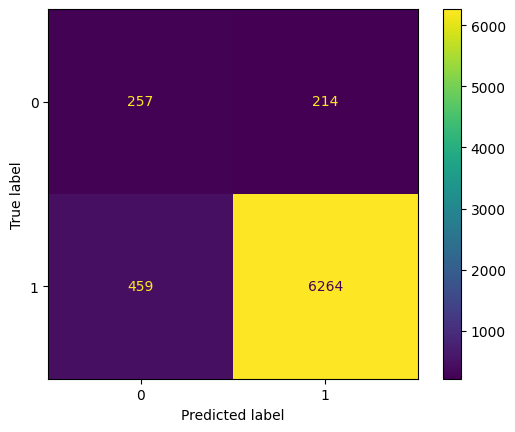

In [137]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(raw_prediction, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

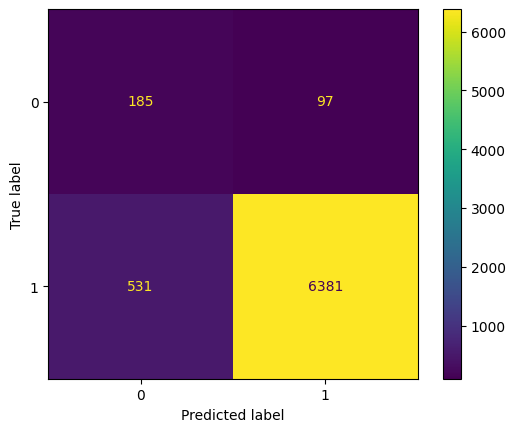

In [140]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(P_prod, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

              precision    recall  f1-score   support

       False       0.43      0.53      0.47       578
        True       0.96      0.94      0.95      6616

    accuracy                           0.90      7194
   macro avg       0.69      0.73      0.71      7194
weighted avg       0.92      0.90      0.91      7194



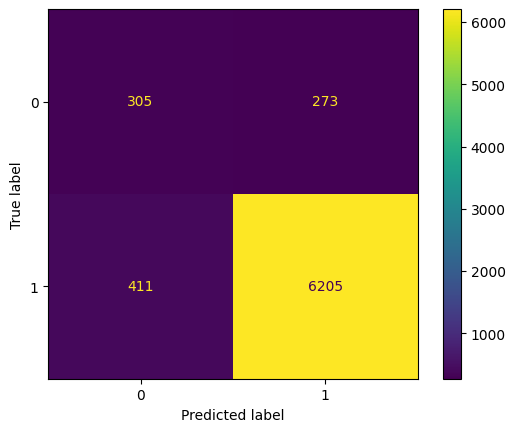

In [150]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

p_manual = grid.best_estimator_.predict_proba(X_val)[:, 1] > 0.6

print(classification_report(p_manual, y_val))
cm = confusion_matrix(p_manual, y_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [78]:
def choose_best_threshold(probas, target):
    ''' iterates over thresholds to choose the one with the highest f1 score '''
    results = dict()
    precision, recall, thresholds = precision_recall_curve(target, probas)
    f1_scores = 2 * recall * precision / (recall + precision)
    best_f1_ind = np.argmax(f1_scores)
    results['best_threshold'] = thresholds[best_f1_ind]
    results['validation_precision']      = precision[best_f1_ind]
    results['validation_recall']         = recall[best_f1_ind]
    results['validation_f1_score']  = np.max(f1_scores)
    return results 